## Bibliotecas

In [46]:
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

import urllib.request, json
import numpy as np
from keras.src.layers import TimeDistributed, Dropout

In [47]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Dados

In [48]:
res = urllib.request.urlopen("http://127.0.0.1:8000/api/vagas/")
data = json.loads(res.read())
vagas = data['data']

## Tratamento dos dados

In [49]:
sentences = []
y = []

for vaga in vagas:
    sentences.append(vaga['txtVaga'].replace("\n", " ").lower())
    y.append(vaga['isApplied'])

char_set = ['<pad>'] + sorted(list(set(''.join(sentences)))) + ['<_unknow']
idx2char = {idx: char for idx, char in enumerate(char_set)}
char2idx = {char: idx for idx, char in enumerate(char_set)}

json_str = json.dumps(char2idx, ensure_ascii=False)
json_str = json.loads(json_str)
with open('char2idx.json', 'w', encoding='utf-8') as json_file:
    json.dump(json_str, json_file, ensure_ascii=False)

X = list(map(lambda sentence: [char2idx.get(char) for char in sentence], sentences))
max_sequence = max(list(map(lambda word: len(word), X)))
X = pad_sequences(sequences=X, maxlen=max_sequence, padding='post', truncating='post')

## Modelo

In [50]:
input_dim = len(char2idx)
output_dim = len(char2idx)
buffer_size  = output_dim
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(buffer_size=buffer_size).batch(batch_size=batch_size)

model = Sequential([
    Embedding(input_dim=input_dim, output_dim=output_dim,
              trainable=False, mask_zero=True, input_length=max_sequence,
              embeddings_initializer=tf.keras.initializers.random_normal()),
    SimpleRNN(units=10, return_sequences=True),
    TimeDistributed(Dropout(rate=0.2)),
    SimpleRNN(units=10),
    Dense(units=2)
])

model.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 195, 68)           4624      
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 195, 10)           790       
                                                                 
 time_distributed_4 (TimeDi  (None, 195, 10)           0         
 stributed)                                                      
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 10)                210       
                                                                 
 dense_4 (Dense)             (None, 2)                 22        
                                                                 
Total params: 5646 (22.05 KB)
Trainable params: 1022 (3.99 KB)
Non-trainable params: 4624 (18.06 KB)
___________________

## Treinamento

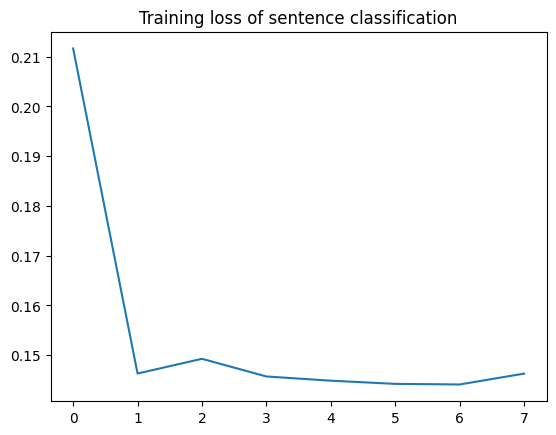

In [51]:
def loss_fn(model, x, y):
    return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(
        y_true=y, y_pred=model(x), from_logits=True
    ))

epoch = 8
tr_loss_hist = []

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

for e in range(epoch):
    avg_tr_loss = 0
    tr_step = 0
    
    for x_mb, y_mb in train_ds:
        with tf.GradientTape() as tape:
            tr_loss = loss_fn(model, x=x_mb, y=y_mb)
        grads = tape.gradient(target=tr_loss, sources=model.trainable_variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.trainable_variables))
        avg_tr_loss += tr_loss
        tr_step += 1
        
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)
    
plt.figure()
plt.plot(tr_loss_hist)
plt.title('Training loss of sentence classification')
plt.show()

## Inferencia

In [52]:
prediction = model.predict(X)
prediction = np.argmax(prediction, axis=-1)
print('Accuracy: {:.2%}'.format(np.mean(prediction == y)))

21/21 [==============================] - 1s 19ms/step
Accuracy: 96.68%


In [56]:
exemples = [
    "desenvolvedor java júnior remoto",
    "desenvolvedor(a) junior alelo novo híbrido tempo integral"
]

newX = list(map(lambda sentence: [char2idx.get(char) for char in sentence], exemples))
newX = pad_sequences(sequences=newX, maxlen=max_sequence, padding='post', truncating='post')
prediction = model.predict(newX)
print(prediction)
prediction = np.argmax(prediction, axis=-1)
print(prediction)

1/1 [==============================] - 0s 24ms/step
[[ 1.7447104 -1.7872877]
 [ 1.6784729 -1.6687839]]
[0 0]


In [54]:
model.save('model.keras')